# 1. Install Dependencies
Install the required libraries for the segmentation pipeline. We use `segmentation-models-pytorch` for the model architectures, `timm` for the pre-trained encoders, and `albumentations` for heavy data augmentation.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip it into the Colab environment
!unzip -q "/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install -q segmentation-models-pytorch albumentations timm tqdm opencv-python seaborn scikit-learn

# 2. Preprocessing & Dataset Pipeline
Define heavy augmentations (CLAHE, Noise, Blur, Color Jitter) to bridge the Synthetic-to-Real gap, and create the PyTorch Dataset.

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Define the Heavy Augmentation Pipeline for Training
# Goal: Degrade the "perfect" synthetic images to look like real, dirty offroad camera footage
train_transform = A.Compose([
    # Geometric: Scale invariance and flipping
    A.RandomResizedCrop(size=(512, 512), scale=(0.5, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    
    # Photometric: Break the synthetic colors
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2, p=0.8),
    A.RandomGamma(gamma_limit=(70, 130), p=0.3),
    
    # Realistic Outdoor Artifacts (Crucial for Synthetic-to-Real)
    A.RandomShadow(p=0.3),
    A.Spatter(p=0.2), # Simulates mud/dirt/rain on the camera lens
    
    # Sensor/Camera Degradation
    A.ImageCompression(quality_range=(60, 90), p=0.3), # JPEG artifacts (Updated API)
    A.MotionBlur(blur_limit=7, p=0.3),
    A.GaussNoise(std_range=(0.015, 0.035), p=0.3),
    A.ISONoise(p=0.3),
    
    # Standard Normalization for ImageNet weights
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 2. Digital Image Processing (DIP) Pipeline for Validation & Testing
# Goal: Enhance real images. Since test images are "color similar", we use CLAHE and Sharpening 
# to force contrast, separate similar colors, and pop the edges of obstacles.
val_transform = A.Compose([
    A.Resize(height=512, width=512),
    
    # DIP Enhancements (Applied 100% of the time during testing)
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0), # Fixes washed-out/similar colors
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0), # Pops the edges of obstacles
    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 3. Define the Dataset Class
class DesertSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.images = sorted(os.listdir(self.image_dir))
        
        # Mapping raw pixel values to class IDs (0 to 9)
        self.value_map = {
            0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
            550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
        }

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load Image (Convert BGR to RGB for Albumentations/PyTorch)
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load Mask (Keep unchanged to read raw values like 100, 7100, etc.)
        mask_path = os.path.join(self.masks_dir, img_name)
        raw_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if raw_mask is None:
            raise FileNotFoundError(f"Could not load mask: {mask_path}")
        
        # Convert raw mask values to 0-9 class IDs
        mask = np.zeros_like(raw_mask, dtype=np.int64)
        for raw_val, class_id in self.value_map.items():
            mask[raw_mask == raw_val] = class_id
            
        # Apply Albumentations transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Mask needs to be long tensor for CrossEntropyLoss
        return image, mask.long()

# --- SETUP DATALOADERS ---
# Update these paths if your data is located elsewhere
TRAIN_DIR = 'dataset/train/Offroad_Segmentation_Training_Dataset/train'
VAL_DIR = 'dataset/train/Offroad_Segmentation_Training_Dataset/val'

# Batch size 8 is safe for 16GB T4 GPU with 512x512 images and MiT-B2
train_dataset = DesertSegmentationDataset(TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = DesertSegmentationDataset(VAL_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")

Loaded 2857 training images and 317 validation images.


# 3. Model, Loss, Optimizer, and Training Loop
Initialize the SegFormer (MiT-B2) model, set up the CrossEntropy + Dice Loss, and run the training loop using Automatic Mixed Precision (AMP) to train twice as fast and use half the GPU memory.

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Initialize Model: Unet with SegFormer (MiT-B2) backbone
# Note: UnetPlusPlus does not support mit_b2, so we use standard Unet
model = smp.Unet(
    encoder_name="mit_b2",        # SegFormer backbone (excellent for domain generalization)
    encoder_weights="imagenet",   # Pre-trained on ImageNet
    in_channels=3,                # RGB images
    classes=10                    # 10 classes in your dataset
).to(device)

# 2. Define Hybrid Loss (Focal Loss + Dice Loss)
# CHANGED: Replaced CrossEntropy with FocalLoss. 
# Focal Loss heavily penalizes the model for getting "hard" pixels wrong (like thin grass strands)
# and naturally balances rare classes (like Logs, Ground Clutter) against common ones (Sky, Landscape).
focal_loss = smp.losses.FocalLoss(mode='multiclass', alpha=0.5, gamma=2.0)
dice_loss = smp.losses.DiceLoss(mode='multiclass')

def criterion(y_pred, y_true):
    return 0.5 * focal_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# --- NEW: Metrics Calculation Functions ---
def calculate_metrics(preds, targets, num_classes=10):
    """Calculates Pixel Accuracy and Mean Intersection over Union (mIoU)"""
    # Convert logits to class predictions
    preds = torch.argmax(preds, dim=1)
    
    # Pixel Accuracy
    correct = (preds == targets).sum().item()
    total = targets.numel()
    pixel_acc = correct / total
    
    # mIoU
    iou_list = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds[target_inds]).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            # If class is not present in both prediction and target, ignore it
            continue
        iou_list.append(intersection / union)
        
    miou = sum(iou_list) / len(iou_list) if iou_list else 0.0
    return pixel_acc, miou

# 3. Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 4. AMP Scaler for Free GPU Memory Optimization
scaler = torch.cuda.amp.GradScaler()

# 5. Training Loop
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # --- TRAINING ---
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_miou = 0.0
    
    # tqdm for progress bar
    train_bar = tqdm(train_loader, desc="Training")
    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Forward Pass
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)
            
        # Mixed Precision Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calculate Metrics
        acc, miou = calculate_metrics(outputs, masks)
        
        train_loss += loss.item()
        train_acc += acc
        train_miou += miou
        
        train_bar.set_postfix(loss=loss.item(), acc=acc, miou=miou)
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    avg_train_miou = train_miou / len(train_loader)
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_miou = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device)
            
            # Mixed Precision Forward Pass (saves memory during val too)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            # Calculate Metrics
            acc, miou = calculate_metrics(outputs, masks)
                
            val_loss += loss.item()
            val_acc += acc
            val_miou += miou
            
            val_bar.set_postfix(loss=loss.item(), acc=acc, miou=miou)
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    avg_val_miou = val_miou / len(val_loader)
    
    scheduler.step() # Update learning rate
    
    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc:.4f} | mIoU: {avg_train_miou:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Acc: {avg_val_acc:.4f} | mIoU: {avg_val_miou:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_model.pth")
        print("--> Saved new best model!")

print("\nTraining Complete! Best model saved as 'best_segformer_model.pth'")

# Download the model to your local machine
try:
    from google.colab import files
    files.download("best_segformer_model.pth")
    print("Downloading model to your local machine...")
except ImportError:
    print("Not running in Colab, skipping download.")

Using device: cuda

Epoch 1/20


/tmp/ipython-input-3208765901.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9358 | Acc: 0.7306 | mIoU: 0.2907
Val Loss:   0.6304 | Acc: 0.7996 | mIoU: 0.2972 | LR: 0.000099
--> Saved new best model!

Epoch 2/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6084 | Acc: 0.8154 | mIoU: 0.3975
Val Loss:   0.5557 | Acc: 0.7934 | mIoU: 0.3103 | LR: 0.000098
--> Saved new best model!

Epoch 3/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5182 | Acc: 0.8289 | mIoU: 0.4521
Val Loss:   0.4951 | Acc: 0.8154 | mIoU: 0.3619 | LR: 0.000095
--> Saved new best model!

Epoch 4/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4724 | Acc: 0.8371 | mIoU: 0.4878
Val Loss:   0.4579 | Acc: 0.8231 | mIoU: 0.4019 | LR: 0.000091
--> Saved new best model!

Epoch 5/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4429 | Acc: 0.8437 | mIoU: 0.5079
Val Loss:   0.4408 | Acc: 0.8311 | mIoU: 0.4076 | LR: 0.000086
--> Saved new best model!

Epoch 6/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4251 | Acc: 0.8478 | mIoU: 0.5192
Val Loss:   0.4268 | Acc: 0.8351 | mIoU: 0.4254 | LR: 0.000080
--> Saved new best model!

Epoch 7/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4153 | Acc: 0.8508 | mIoU: 0.5253
Val Loss:   0.4131 | Acc: 0.8413 | mIoU: 0.4328 | LR: 0.000073
--> Saved new best model!

Epoch 8/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4045 | Acc: 0.8534 | mIoU: 0.5334
Val Loss:   0.4060 | Acc: 0.8441 | mIoU: 0.4488 | LR: 0.000066
--> Saved new best model!

Epoch 9/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3971 | Acc: 0.8555 | mIoU: 0.5377
Val Loss:   0.3994 | Acc: 0.8453 | mIoU: 0.4619 | LR: 0.000058
--> Saved new best model!

Epoch 10/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3908 | Acc: 0.8568 | mIoU: 0.5437
Val Loss:   0.3963 | Acc: 0.8467 | mIoU: 0.4544 | LR: 0.000051
--> Saved new best model!

Epoch 11/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3790 | Acc: 0.8583 | mIoU: 0.5689
Val Loss:   0.3973 | Acc: 0.8457 | mIoU: 0.4698 | LR: 0.000043

Epoch 12/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3676 | Acc: 0.8593 | mIoU: 0.5795
Val Loss:   0.3871 | Acc: 0.8481 | mIoU: 0.4684 | LR: 0.000035
--> Saved new best model!

Epoch 13/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3594 | Acc: 0.8609 | mIoU: 0.5864
Val Loss:   0.3781 | Acc: 0.8498 | mIoU: 0.4826 | LR: 0.000028
--> Saved new best model!

Epoch 14/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3663 | Acc: 0.8588 | mIoU: 0.5878
Val Loss:   0.3776 | Acc: 0.8499 | mIoU: 0.4902 | LR: 0.000021
--> Saved new best model!

Epoch 15/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3537 | Acc: 0.8614 | mIoU: 0.5947
Val Loss:   0.3772 | Acc: 0.8497 | mIoU: 0.4787 | LR: 0.000015
--> Saved new best model!

Epoch 16/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3520 | Acc: 0.8617 | mIoU: 0.5952
Val Loss:   0.3753 | Acc: 0.8511 | mIoU: 0.4926 | LR: 0.000010
--> Saved new best model!

Epoch 17/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3493 | Acc: 0.8625 | mIoU: 0.5962
Val Loss:   0.3728 | Acc: 0.8511 | mIoU: 0.4937 | LR: 0.000006
--> Saved new best model!

Epoch 18/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3496 | Acc: 0.8624 | mIoU: 0.5981
Val Loss:   0.3730 | Acc: 0.8508 | mIoU: 0.4926 | LR: 0.000003

Epoch 19/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3474 | Acc: 0.8628 | mIoU: 0.6005
Val Loss:   0.3730 | Acc: 0.8517 | mIoU: 0.4898 | LR: 0.000002

Epoch 20/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3471 | Acc: 0.8630 | mIoU: 0.5999
Val Loss:   0.3712 | Acc: 0.8515 | mIoU: 0.4889 | LR: 0.000001
--> Saved new best model!

Training Complete! Best model saved as 'best_segformer_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Test the Model and Visualize Results
Now that the model is trained, let's load the best saved weights and test it on some images from the validation set to see how well it performs visually.

Using device: cuda
Initializing model architecture and loading weights from: best_segformer_model.pth
Calculating Test Loss, Accuracy, and mIoU over the entire test set using TTA and DIP...
✅ Average Test Loss: 0.8583
✅ Average Test Pixel Accuracy: 0.6822
✅ Average Test mIoU: 0.2815

Generating visualizations for the first 4 images...
Saved comparison plot to test_results/test_comparison.png


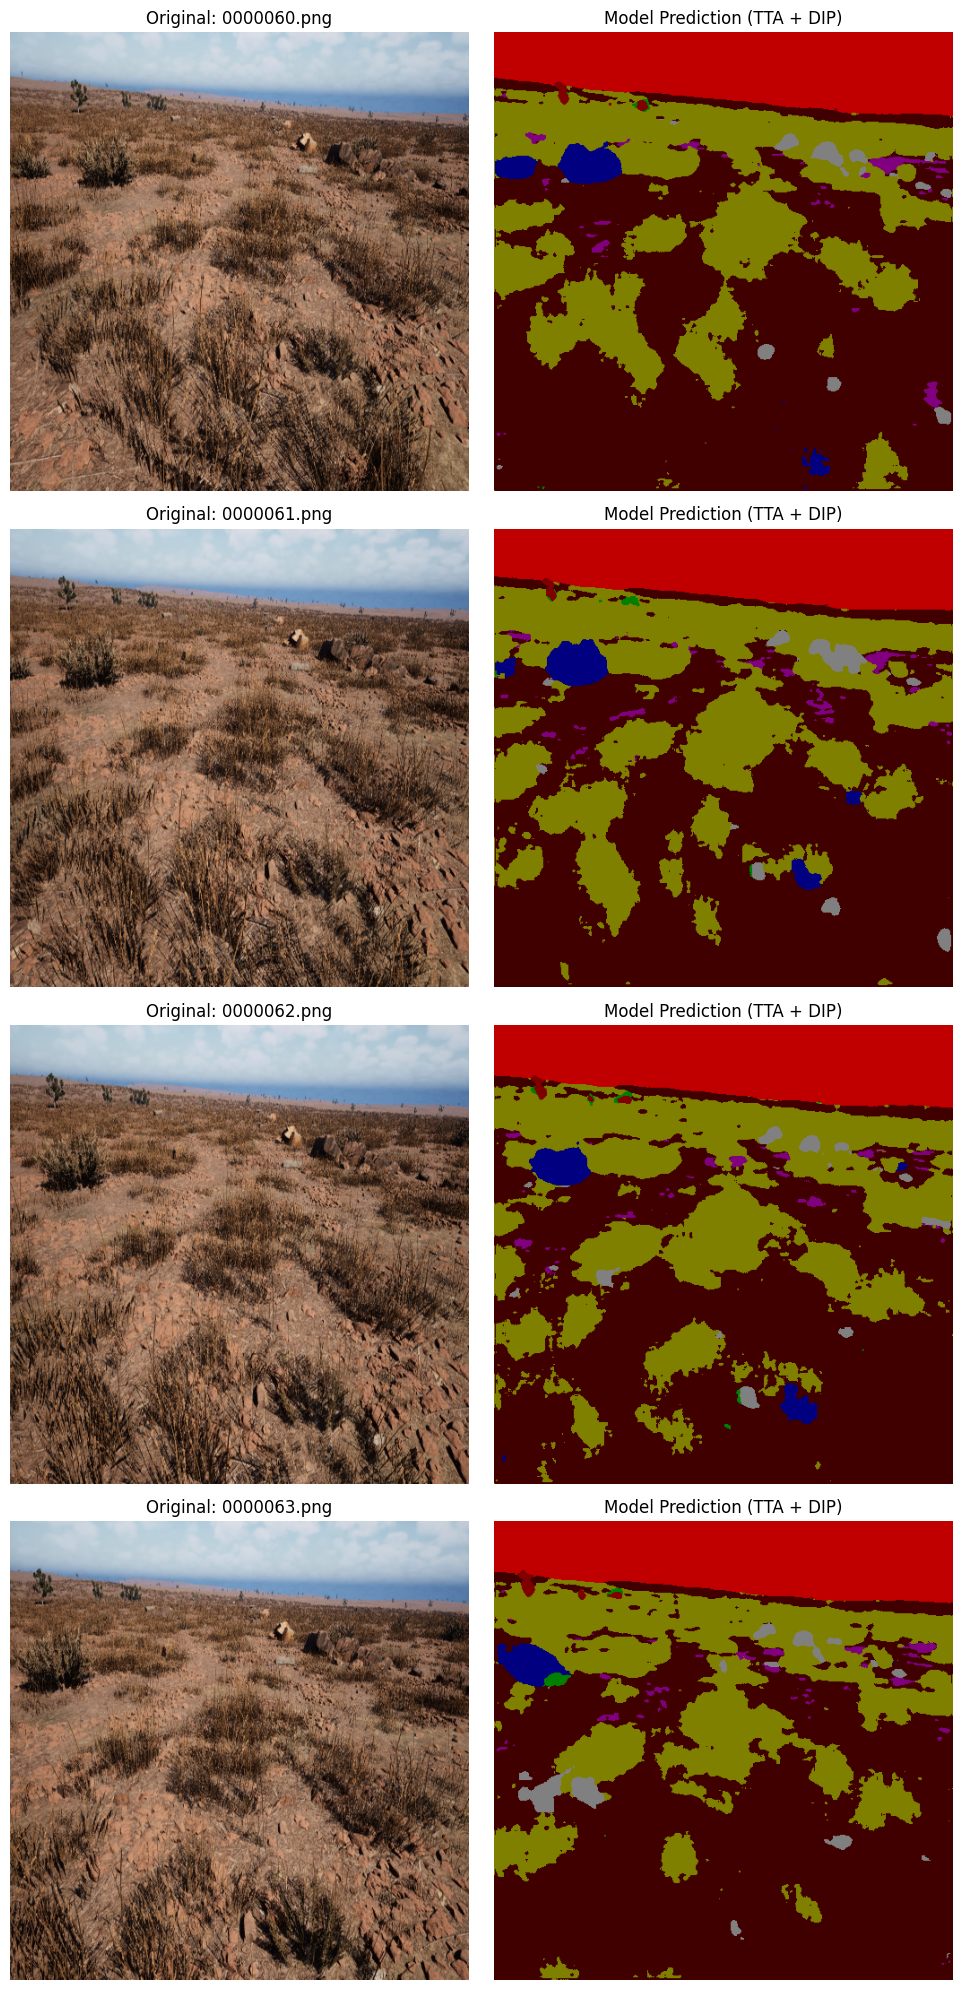

Zipping results and downloading to your local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

# --- NEW: Handle Colab Unzipping and Paths ---
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    if not os.path.exists('/content/Offroad_Segmentation_testImages'):
        print("Unzipping test dataset from Google Drive...")
        os.system('unzip -q "/content/drive/MyDrive/Offroad_Segmentation_testImages.zip" -d "/content/"')
    TEST_BASE_DIR = '/content/Offroad_Segmentation_testImages'
else:
    TEST_BASE_DIR = 'Offroad_Segmentation_testImages'

TEST_DIR = os.path.join(TEST_BASE_DIR, 'Color_Images')

# 1. Initialize the model architecture and load the best weights from local storage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_path = "best_segformer_model.pth"
if not os.path.exists(model_path):
    print(f"❌ Could not find model weights at: {model_path}")
    print("Please ensure you have trained the model or downloaded the weights to this directory.")
else:
    print(f"Initializing model architecture and loading weights from: {model_path}")
    # Re-initialize the model architecture
    model = smp.Unet(
        encoder_name="mit_b2",
        encoder_weights=None, # Don't need imagenet weights since we are loading our own
        in_channels=3,
        classes=10
    ).to(device)
    
    # Load weights, mapping to CPU if CUDA is not available
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

# 2. Define a color map for the 10 classes to make the output readable
# Updated to match the actual dataset classes
color_map = np.array([
    [0, 0, 0],         # Class 0: Background (Black)
    [0, 128, 0],       # Class 1: Trees (Dark Green)
    [0, 255, 0],       # Class 2: Lush Bushes (Bright Green)
    [128, 128, 0],     # Class 3: Dry Grass (Olive)
    [139, 69, 19],     # Class 4: Dry Bushes (Saddle Brown)
    [160, 82, 45],     # Class 5: Ground Clutter (Sienna)
    [139, 137, 137],   # Class 6: Logs (Light Gray/Brown)
    [128, 128, 128],   # Class 7: Rocks (Gray)
    [210, 180, 140],   # Class 8: Landscape/Dirt (Tan)
    [135, 206, 235]    # Class 9: Sky (Sky Blue)
])

def decode_segmap(image, nc=10):
    """Converts a 2D array of class IDs into an RGB image."""
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = color_map[l, 0]
        g[idx] = color_map[l, 1]
        b[idx] = color_map[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def predict_with_tta(model, image_tensor):
    """
    Test-Time Augmentation (TTA): Acts like an ensemble of multiple models.
    It runs the image through the model, then flips the image, runs it again, 
    flips the result back, and averages the two predictions.
    """
    # 1. Original prediction
    out1 = model(image_tensor)
    
    # 2. Horizontal flip prediction
    out2 = model(torch.flip(image_tensor, dims=[3]))
    out2 = torch.flip(out2, dims=[3]) # Flip the mask back to align with original
    
    # Average the logits for a more robust, generalized prediction
    return (out1 + out2) / 2.0

# Create a directory to save the output images
output_dir = "test_results"
os.makedirs(output_dir, exist_ok=True)

# 4. Evaluate and Visualize
if not os.path.exists(TEST_BASE_DIR):
    print(f"❌ Could not find test directory: {TEST_BASE_DIR}")
    print("Please make sure you have uploaded 'Offroad_Segmentation_testImages.zip' to your Google Drive.")
elif not os.path.exists(model_path):
    print("Skipping evaluation because model weights were not found.")
else:
    # --- CALCULATE TEST METRICS ---
    print("Calculating Test Loss, Accuracy, and mIoU over the entire test set using TTA and DIP...")
    
    # Re-define criterion if it's not in memory
    import torch.nn as nn
    focal_loss = smp.losses.FocalLoss(mode='multiclass', alpha=0.5, gamma=2.0)
    dice_loss = smp.losses.DiceLoss(mode='multiclass')
    def criterion(y_pred, y_true):
        return 0.5 * focal_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)
        
    # Re-define calculate_metrics if it's not in memory
    def calculate_metrics(preds, targets, num_classes=10):
        preds = torch.argmax(preds, dim=1)
        correct = (preds == targets).sum().item()
        total = targets.numel()
        pixel_acc = correct / total
        
        iou_list = []
        for cls in range(num_classes):
            pred_inds = preds == cls
            target_inds = targets == cls
            intersection = (pred_inds[target_inds]).sum().item()
            union = pred_inds.sum().item() + target_inds.sum().item() - intersection
            if union == 0:
                continue
            iou_list.append(intersection / union)
            
        miou = sum(iou_list) / len(iou_list) if iou_list else 0.0
        return pixel_acc, miou

    # Re-define Dataset and Transforms if they are not in memory
    val_transform = A.Compose([
        A.Resize(height=512, width=512),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    class DesertSegmentationDataset(Dataset):
        def __init__(self, data_dir, transform=None):
            self.image_dir = os.path.join(data_dir, 'Color_Images')
            self.masks_dir = os.path.join(data_dir, 'Segmentation')
            self.transform = transform
            self.images = sorted(os.listdir(self.image_dir))
            self.value_map = {
                0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
                550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
            }

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_name = self.images[idx]
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"Could not load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            mask_path = os.path.join(self.masks_dir, img_name)
            raw_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            if raw_mask is None:
                raise FileNotFoundError(f"Could not load mask: {mask_path}")
            
            mask = np.zeros_like(raw_mask, dtype=np.int64)
            for raw_val, class_id in self.value_map.items():
                mask[raw_mask == raw_val] = class_id
                
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
                
            return image, mask.long()

    test_dataset = DesertSegmentationDataset(TEST_BASE_DIR, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    test_loss = 0.0
    test_acc = 0.0
    test_miou = 0.0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            with torch.amp.autocast('cuda'):
                # Use TTA instead of standard forward pass
                outputs = predict_with_tta(model, images)
                loss = criterion(outputs, masks)
                
            # Calculate Metrics
            acc, miou = calculate_metrics(outputs, masks)
            
            test_loss += loss.item()
            test_acc += acc
            test_miou += miou
            
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)
    avg_test_miou = test_miou / len(test_loader)
    
    print(f"✅ Average Test Loss: {avg_test_loss:.4f}")
    print(f"✅ Average Test Pixel Accuracy: {avg_test_acc:.4f}")
    print(f"✅ Average Test mIoU: {avg_test_miou:.4f}\n")

    # --- VISUALIZE RESULTS ---
    print("Generating visualizations for the first 4 images...")
    test_images = sorted(os.listdir(TEST_DIR))[:4] # Let's test on the first 4 images
    
    fig, axes = plt.subplots(len(test_images), 2, figsize=(10, 5 * len(test_images)))
    
    for i, img_name in enumerate(test_images):
        img_path = os.path.join(TEST_DIR, img_name)
        
        # Load and prepare the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image = image.copy() # Keep a copy for visualization
        
        # Apply transforms (using val_transform to apply CLAHE and Sharpening)
        augmented = val_transform(image=image)
        input_tensor = augmented['image'].unsqueeze(0).to(device) # Add batch dimension
        
        # Run inference with TTA
        with torch.no_grad():
            output = predict_with_tta(model, input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            
        # Decode mask to RGB
        pred_rgb = decode_segmap(pred_mask)
        
        # Resize original image to match the 512x512 prediction for plotting
        original_resized = cv2.resize(original_image, (512, 512))
        
        # Plotting
        axes[i, 0].imshow(original_resized)
        axes[i, 0].set_title(f"Original: {img_name}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_rgb)
        axes[i, 1].set_title("Model Prediction (TTA + DIP)")
        axes[i, 1].axis('off')
        
        # Save individual prediction
        save_path = os.path.join(output_dir, f"pred_{img_name}")
        # Convert RGB back to BGR for OpenCV saving
        cv2.imwrite(save_path, cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR))

    plt.tight_layout()
    
    # Save the combined plot
    plot_path = os.path.join(output_dir, "test_comparison.png")
    plt.savefig(plot_path)
    print(f"Saved comparison plot to {plot_path}")
    plt.show()

    # Zip the results folder and download it
    if IN_COLAB:
        from google.colab import files
        print("Zipping results and downloading to your local machine...")
        os.system(f'zip -r {output_dir}.zip {output_dir}')
        files.download(f"{output_dir}.zip")

# 5. Error Analysis & Per-Class Metrics
Analyze the model's performance on a per-class basis using a Confusion Matrix, Per-Class IoU, and Per-Class Accuracy. This helps identify which specific obstacles or terrain types the model is struggling with.

Computing confusion matrix over the test set (this may take a minute)...


/tmp/ipython-input-2868104212.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_iou, ax=axes[1], palette='viridis')
/tmp/ipython-input-2868104212.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_acc, ax=axes[2], palette='magma')


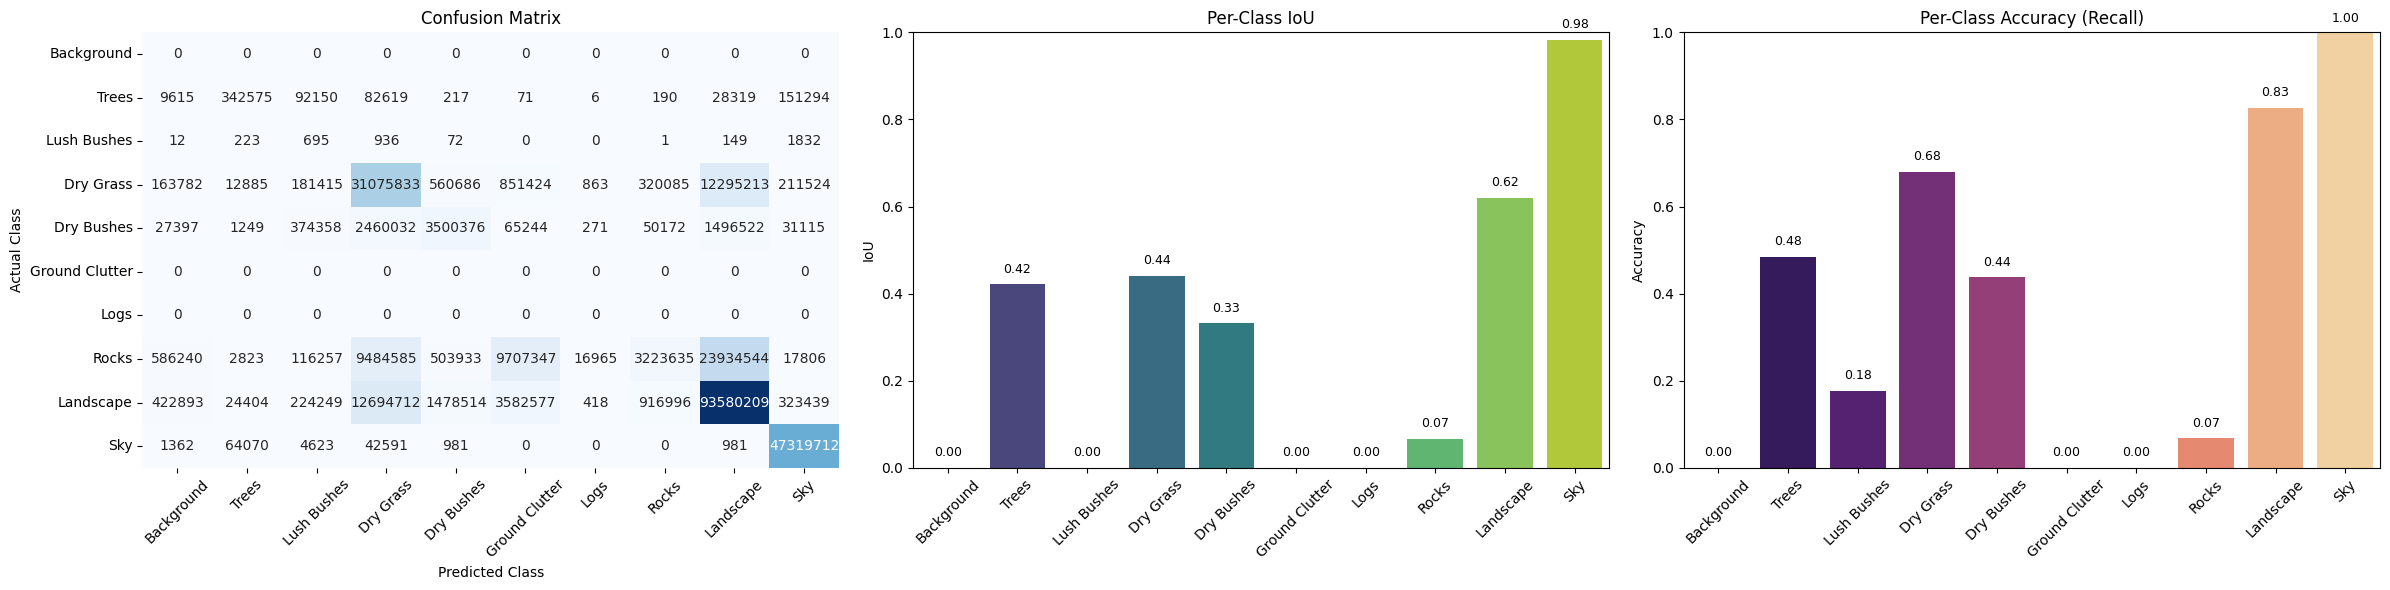


--- Error Analysis Summary ---
Worst performing obstacle by IoU: Ground Clutter (0.0000)
Worst performing obstacle by Accuracy: Ground Clutter (0.0000)

This means the model struggles the most to correctly identify and segment the 'Ground Clutter' class.


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class names for better visualization based on your color map
class_names = [
    "Background", "Trees", "Lush Bushes", "Dry Grass", "Dry Bushes", 
    "Ground Clutter", "Logs", "Rocks", "Landscape", "Sky"
]

def compute_confusion_matrix(model, dataloader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Computing confusion matrix over the test set (this may take a minute)...")
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Use TTA for prediction
            with torch.amp.autocast('cuda'):
                outputs = predict_with_tta(model, images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.append(preds.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())
            
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds, labels=np.arange(num_classes))
    return cm

if 'test_loader' in locals():
    cm = compute_confusion_matrix(model, test_loader, device, num_classes=10)
    
    # Calculate per-class metrics from confusion matrix
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    
    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    per_class_iou = tp / (tp + fp + fn + epsilon)
    per_class_acc = tp / (tp + fn + epsilon)
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Class')
    axes[0].set_ylabel('Actual Class')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. Per-Class IoU
    sns.barplot(x=class_names, y=per_class_iou, ax=axes[1], palette='viridis')
    axes[1].set_title('Per-Class IoU')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('IoU')
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(per_class_iou):
        axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
        
    # 3. Per-Class Accuracy (Recall)
    sns.barplot(x=class_names, y=per_class_acc, ax=axes[2], palette='magma')
    axes[2].set_title('Per-Class Accuracy (Recall)')
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Accuracy')
    axes[2].tick_params(axis='x', rotation=45)
    for i, v in enumerate(per_class_acc):
        axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
        
    plt.tight_layout()
    plt.savefig('error_analysis.png')
    plt.show()
    
    # Print worst performing classes
    print("\n--- Error Analysis Summary ---")
    
    # Ignore background class (index 0) for finding the worst obstacle class
    obstacle_iou = per_class_iou[1:]
    obstacle_acc = per_class_acc[1:]
    
    worst_iou_idx = np.argmin(obstacle_iou) + 1
    worst_acc_idx = np.argmin(obstacle_acc) + 1
    
    print(f"Worst performing obstacle by IoU: {class_names[worst_iou_idx]} ({per_class_iou[worst_iou_idx]:.4f})")
    print(f"Worst performing obstacle by Accuracy: {class_names[worst_acc_idx]} ({per_class_acc[worst_acc_idx]:.4f})")
    
    print(f"\nThis means the model struggles the most to correctly identify and segment the '{class_names[worst_iou_idx]}' class.")
else:
    print("test_loader not found. Please run the previous testing cell first.")